In [1]:
t_end = 'Now'
duration_in_day = 2
figformat = 'retina'
time_interval = '5m'
exclude='cryo3'

In [2]:
%matplotlib inline
%config InlineBackend.figure_formats = [figformat]

Querying global parameters...
Querying 5 cryo units...
  cryo1... OK
  cryo2... OK
  cryo4... OK
  cryo5... OK
  cryo6... OK
Data loading complete!


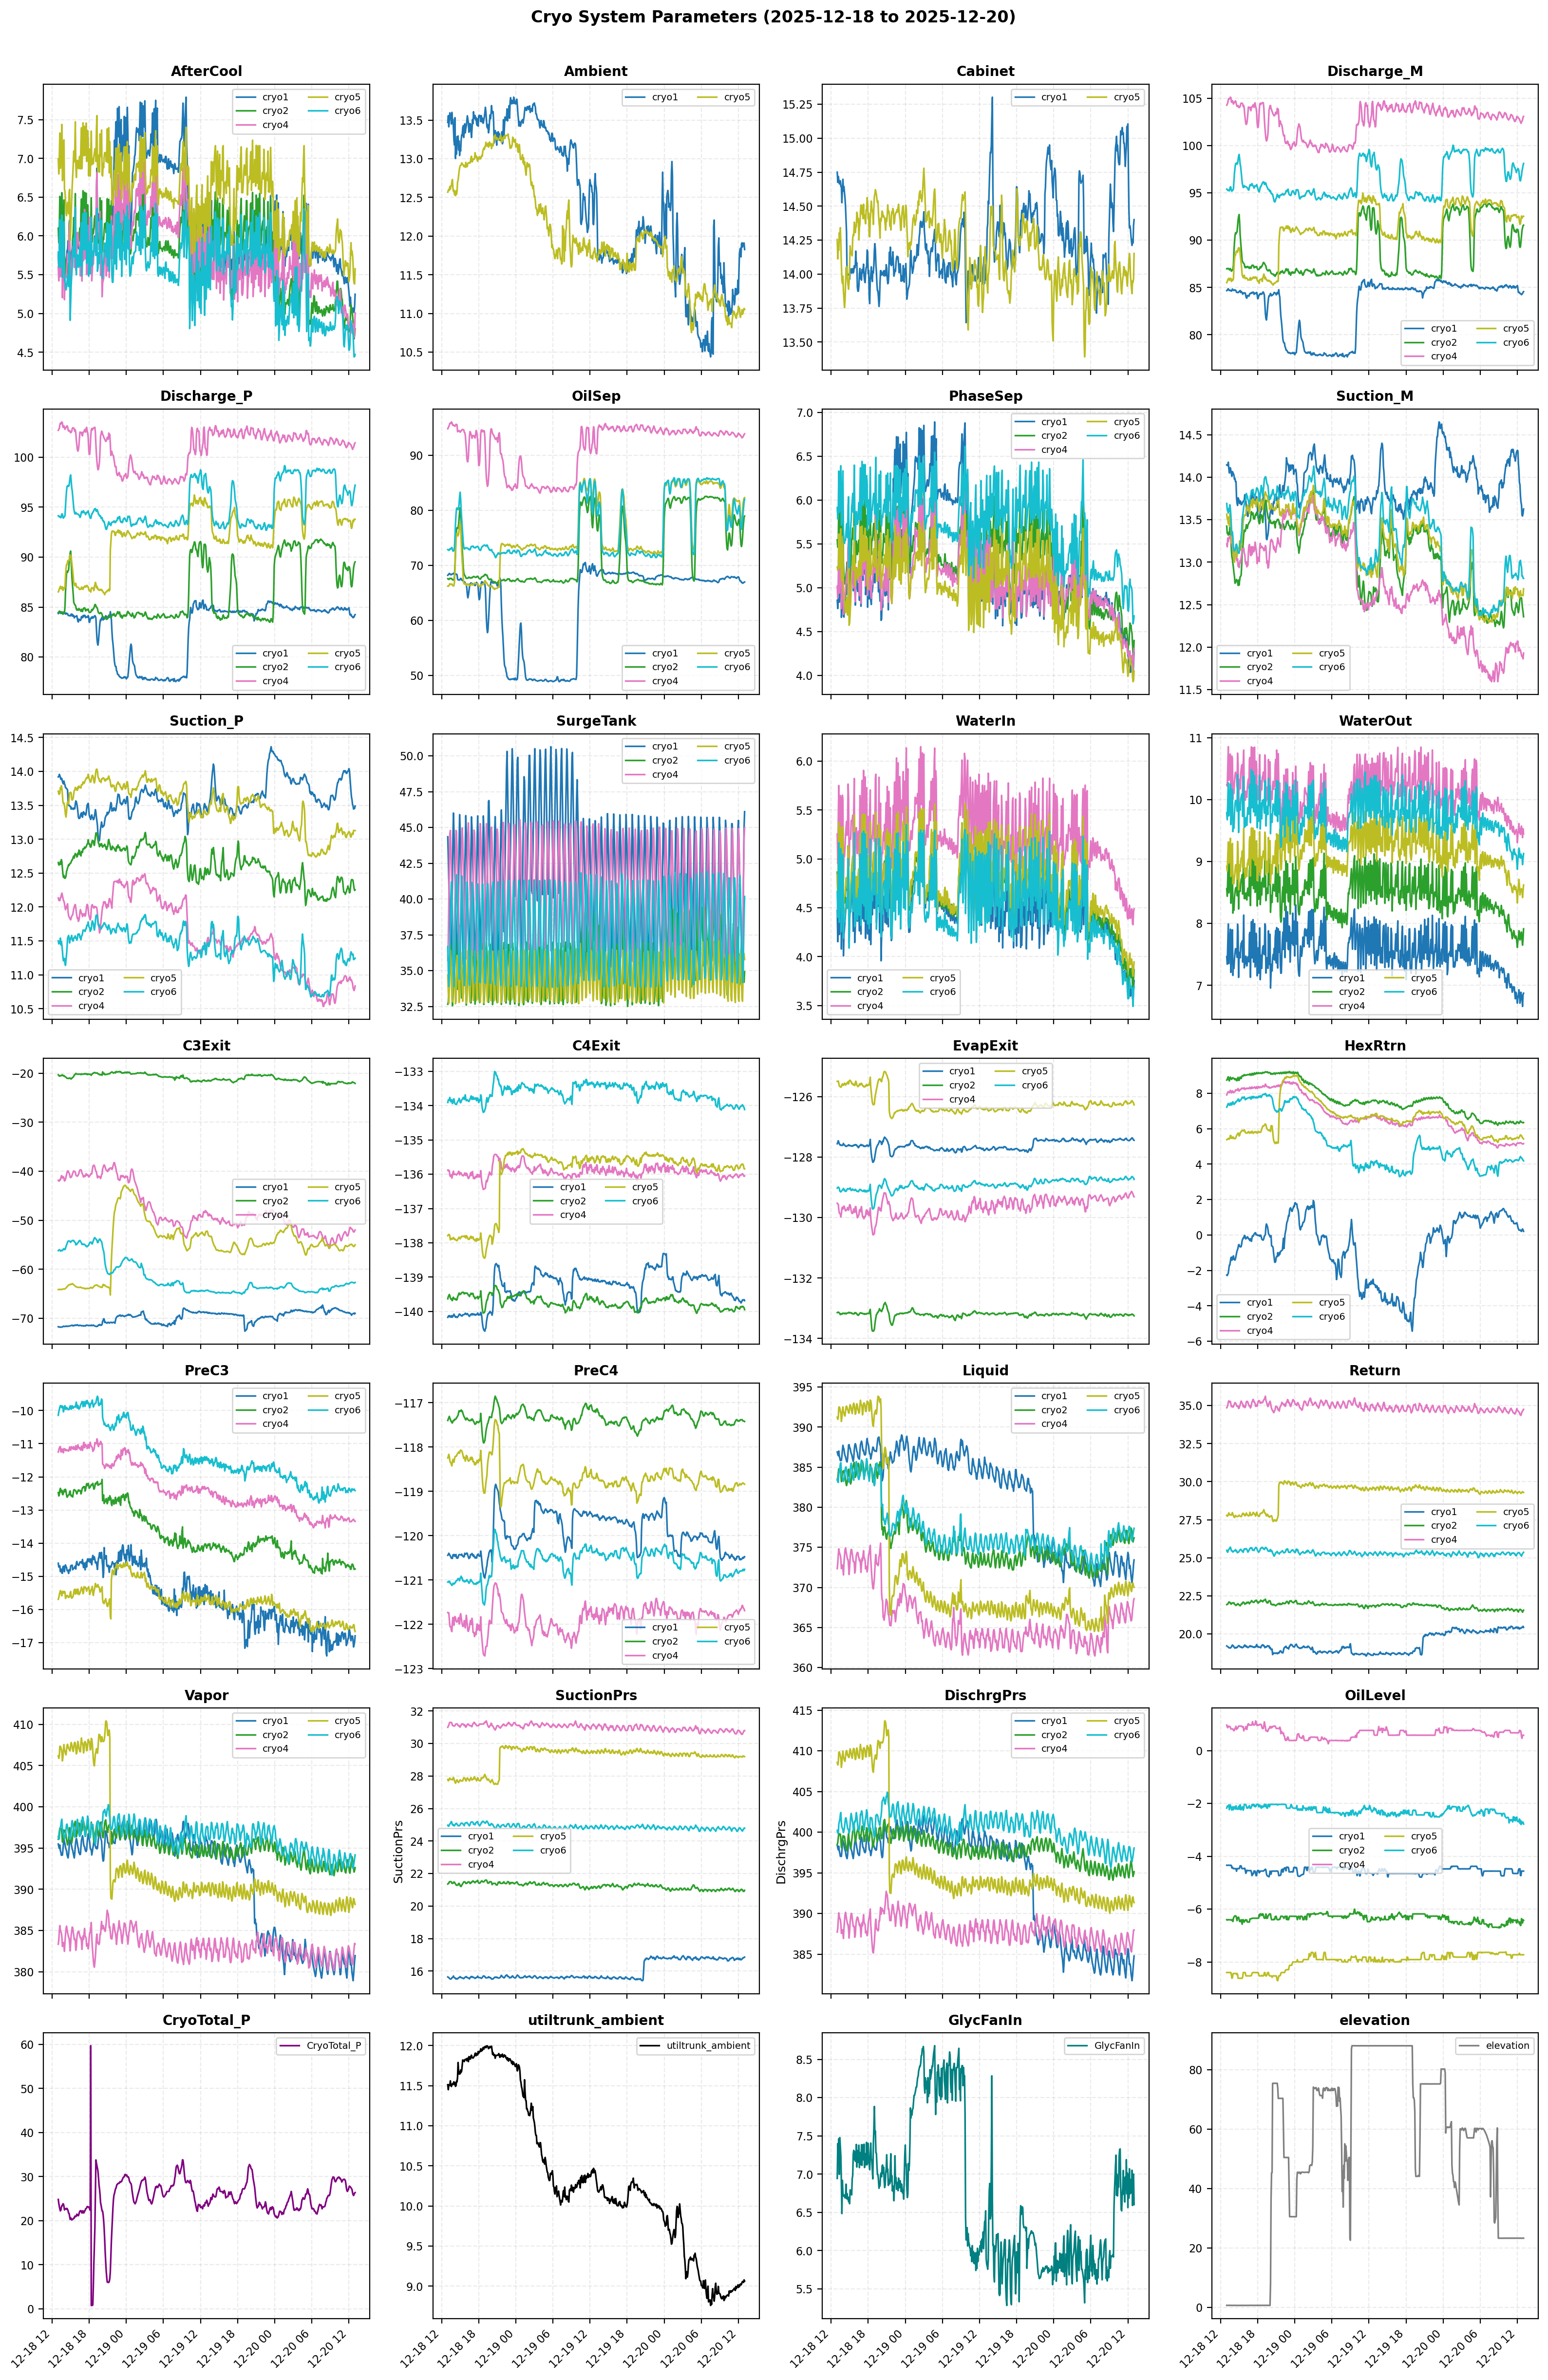

In [4]:
import asyncio
from lsst_efd_client import EfdClient
from datetime import datetime, timezone
import matplotlib.pyplot as plt
from astropy.time import Time, TimeDelta
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

async def load_cryo_data():
    """Async function to load all cryo data"""
    global exclude, t_end, duration_in_day, time_interval
    
    client = EfdClient("usdf_efd")
    
    # Prepare time range (use global t_end)
    if t_end == 'Now':
        t_end_val = Time.now()
    else:
        t_end_val = Time(t_end)
    t_start_val = t_end_val - TimeDelta(duration_in_day, format='jd')
    t_start = t_start_val.iso
    t_end_iso = t_end_val.iso

    def tidy_result(result, label_cols=("Source","Cryo"), override_name=None):
        """Convert EFD query results into a list of DataFrames with single value column"""
        dfs = []
        items = result.values() if isinstance(result, dict) else (result if isinstance(result, list) else [])
        for df in items:
            if df is None or df.empty:
                continue
            label_name = None
            label_col_present = None
            for col in label_cols:
                if col in df.columns and len(df[col]) > 0:
                    label_col_present = col
                    label_name = df[col].iloc[0]
                    break
            if 'mean' in df.columns and 'value' not in df.columns:
                df = df.rename(columns={'mean': 'value'})
            if label_col_present in df.columns:
                df = df.drop(columns=[label_col_present])
            final_name = label_name if label_name else (override_name if override_name else 'value')
            if 'value' in df.columns:
                df = df.rename(columns={'value': final_name})
            dfs.append(df)
        return dfs

    # ステップ1: 各cryo用クエリを関数化
    async def query_cryo_data(cryo):
        """Query all data for a single cryo in one batch"""
        queries_results = {}
        
        # refrig_cryo_temp
        queries_results['refrig'] = await client.influx_client.query(f'''
        SELECT mean("temperature")
        FROM "lsst.MTCamera"."autogen"."lsst.MTCamera.refrig_cryo_temp"
        WHERE time > '{t_start}' AND time < '{t_end_iso}'
          AND "Cryo"='{cryo}' AND "Agent"='refrig2'
        GROUP BY time({time_interval}), "Source" FILL(null)
        ''')
        
        # hex_cryo_temp
        queries_results['hex_temp'] = await client.influx_client.query(f'''
        SELECT mean("temperature")
        FROM "lsst.MTCamera"."autogen"."lsst.MTCamera.hex_cryo_temp"
        WHERE time > '{t_start}' AND time < '{t_end_iso}' AND "Cryo"='{cryo}'
        GROUP BY time({time_interval}), "Source" FILL(null)
        ''')
        
        # hex_cryo_pressure
        queries_results['hex_pres'] = await client.influx_client.query(f'''
        SELECT mean("pressure")
        FROM "lsst.MTCamera"."autogen"."lsst.MTCamera.hex_cryo_pressure"
        WHERE time > '{t_start}' AND time < '{t_end_iso}' AND "Cryo"='{cryo}'
        GROUP BY time({time_interval}), "Source" FILL(null)
        ''')
        
        # refrig_cryo (油位・圧力)
        queries_results['oil'] = await client.influx_client.query(f'''
        SELECT mean("OilLevel") AS "OilLevel", mean("SuctionPrs") AS "mean_SuctionPrs", mean("DischrgPrs") AS "mean_DischrgPrs"
        FROM "lsst.MTCamera"."autogen"."lsst.MTCamera.refrig_cryo"
        WHERE time > '{t_start}' AND time < '{t_end_iso}' AND "Agent"='refrig2' AND "Cryo"='{cryo}'
        GROUP BY time({time_interval}) FILL(null)
        ''')
        
        return queries_results

    # ステップ2: グローバルデータを一度だけ取得
    print("Querying global parameters...")
    utiltrunk_result = await client.influx_client.query(f'''
    SELECT mean("AmbAirtemp") AS "utiltrunk_ambient"
    FROM "lsst.MTCamera"."autogen"."lsst.MTCamera.utiltrunk_body"
    WHERE time > '{t_start}' AND time < '{t_end_iso}' AND "Agent"='utiltrunk'
    GROUP BY time({time_interval}) FILL(null)
    ''')
    utiltrunk_ambient = utiltrunk_result['utiltrunk_ambient'] if isinstance(utiltrunk_result, pd.DataFrame) and 'utiltrunk_ambient' in utiltrunk_result.columns else None
    utiltrunk_dates = pd.to_datetime(utiltrunk_result.index) if utiltrunk_ambient is not None else None

    thermal_result = await client.influx_client.query(f'''
    SELECT mean("CryoTotal_P") AS "CryoTotal_P"
    FROM "lsst.MTCamera"."autogen"."lsst.MTCamera.thermal_trim_bulk"
    WHERE time > '{t_start}' AND time < '{t_end_iso}'
    GROUP BY time({time_interval}) FILL(null)
    ''')
    cryo_total_p = thermal_result['CryoTotal_P'] if isinstance(thermal_result, pd.DataFrame) and 'CryoTotal_P' in thermal_result.columns else None
    cryo_total_p_dates = pd.to_datetime(thermal_result.index) if cryo_total_p is not None else None

    chiller_result = await client.influx_client.query(f'''
    SELECT mean("GlycFanIn") AS "mean_GlycFanIn"
    FROM "lsst.MTCamera"."autogen"."lsst.MTCamera.chiller_maq20"
    WHERE time > '{t_start}' AND time < '{t_end_iso}'
    GROUP BY time({time_interval}) FILL(null)
    ''')
    chiller_glyc = chiller_result['mean_GlycFanIn'] if isinstance(chiller_result, pd.DataFrame) and 'mean_GlycFanIn' in chiller_result.columns else None
    chiller_glyc_dates = pd.to_datetime(chiller_result.index) if chiller_glyc is not None else None

    fcs_result = await client.influx_client.query(f'''
    SELECT mean("elevation") AS "mean_elevation"
    FROM "lsst.MTCamera"."autogen"."lsst.MTCamera.fcs_canbus_controller"
    WHERE time > '{t_start}' AND time < '{t_end_iso}'
    GROUP BY time({time_interval}) FILL(null)
    ''')
    fcs_elevation = fcs_result['mean_elevation'] if isinstance(fcs_result, pd.DataFrame) and 'mean_elevation' in fcs_result.columns else None
    fcs_elevation_dates = pd.to_datetime(fcs_result.index) if fcs_elevation is not None else None

    # ステップ3: Cryo別データを取得・統合
    sources_by_table = {'refrig_cryo_temp': set(), 'hex_cryo_temp': set(), 'hex_cryo_pressure': set(), 'refrig_cryo': set()}
    cryo_data = {}
    cryo_list = [f'cryo{i+1}' for i in range(6)]
    if exclude is not None:
        exclude_set = {exclude} if isinstance(exclude, str) else set(exclude)
        cryo_list = [c for c in cryo_list if c not in exclude_set]

    print(f"Querying {len(cryo_list)} cryo units...")
    for cryo in cryo_list:
        print(f"  {cryo}...", end='', flush=True)
        qr = await query_cryo_data(cryo)
        
        refrig_dfs = tidy_result(qr['refrig'], label_cols=("Source","Cryo"))
        df_refrig = pd.concat(refrig_dfs, axis=1) if refrig_dfs else pd.DataFrame()
        sources_by_table['refrig_cryo_temp'].update(df_refrig.columns.tolist())

        hex_temp_dfs = tidy_result(qr['hex_temp'], label_cols=("Source","Cryo"))
        df_hex = pd.concat(hex_temp_dfs, axis=1) if hex_temp_dfs else pd.DataFrame()
        sources_by_table['hex_cryo_temp'].update(df_hex.columns.tolist())

        hex_pres_dfs = tidy_result(qr['hex_pres'], label_cols=("Source","Cryo"))
        df_pressure = pd.concat(hex_pres_dfs, axis=1) if hex_pres_dfs else pd.DataFrame()
        sources_by_table['hex_cryo_pressure'].update(df_pressure.columns.tolist())

        # oil_result is typically a DataFrame from async query
        oil_result = qr['oil']
        df_oil = pd.DataFrame()
        if isinstance(oil_result, pd.DataFrame) and not oil_result.empty:
            # Rename OilLevel column if it exists
            if 'OilLevel' in oil_result.columns:
                oil_result = oil_result.rename(columns={'OilLevel': f'OilLevel_{cryo}'})
                sources_by_table['refrig_cryo'].add(f'OilLevel_{cryo}')
            # Add pressure columns directly
            if 'mean_SuctionPrs' in oil_result.columns:
                sources_by_table['refrig_cryo'].add('mean_SuctionPrs')
            if 'mean_DischrgPrs' in oil_result.columns:
                sources_by_table['refrig_cryo'].add('mean_DischrgPrs')
            df_oil = oil_result
        
        df_all = pd.concat([df_refrig, df_hex, df_pressure, df_oil], axis=1)
        cryo_data[cryo] = df_all
        print(" OK")

    # ステップ4: グループ化されたソースを準備
    grouped_sources = []
    for tbl in ['refrig_cryo_temp', 'hex_cryo_temp']:
        grouped_sources.extend([(tbl, s) for s in sorted(sources_by_table[tbl])])
    grouped_sources.extend([(f'hex_cryo_pressure', s) for s in sorted(sources_by_table['hex_cryo_pressure'])])
    grouped_sources.append(('refrig_cryo', 'SuctionPrs'))
    grouped_sources.append(('refrig_cryo', 'DischrgPrs'))
    if sources_by_table['refrig_cryo']:
        grouped_sources.append(('refrig_cryo', 'OilLevel'))
    if cryo_total_p is not None:
        grouped_sources.append(('thermal_trim_bulk', 'CryoTotal_P'))
    if utiltrunk_ambient is not None:
        grouped_sources.append(('utiltrunk_ambient', 'utiltrunk_ambient'))
    if chiller_glyc is not None:
        grouped_sources.append(('chiller_maq20', 'GlycFanIn'))
    if fcs_elevation is not None:
        grouped_sources.append(('fcs_canbus_controller', 'elevation'))

    # ステップ5: 高速で綺麗な描画
    n_sources = len(grouped_sources)
    ncols = 4  # より均衡的なレイアウト
    nrows = int(np.ceil(n_sources / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 3.5*nrows), sharex=True)
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]
    cryo_colors = plt.cm.tab10(np.linspace(0, 1, 6))

    for idx, (tbl, source) in enumerate(grouped_sources):
        ax = axes[idx]
        plotted = False
        
        if tbl == 'refrig_cryo' and source == 'OilLevel':
            for i, cryo in enumerate([f'cryo{j+1}' for j in range(6)]):
                if cryo not in cryo_data:
                    continue
                col = f'OilLevel_{cryo}'
                if col in cryo_data[cryo].columns:
                    dates = pd.to_datetime(cryo_data[cryo].index)
                    ax.plot(dates, cryo_data[cryo][col], label=cryo, color=cryo_colors[i], linewidth=1.2)
                    plotted = True
        elif tbl in ['refrig_cryo_temp', 'hex_cryo_temp', 'hex_cryo_pressure']:
            for i, cryo in enumerate([f'cryo{j+1}' for j in range(6)]):
                if cryo not in cryo_data or source not in cryo_data[cryo].columns:
                    continue
                dates = pd.to_datetime(cryo_data[cryo].index)
                ax.plot(dates, cryo_data[cryo][source], label=cryo, color=cryo_colors[i], linewidth=1.2)
                plotted = True
        elif tbl == 'utiltrunk_ambient' and utiltrunk_ambient is not None:
            ax.plot(utiltrunk_dates, utiltrunk_ambient, label='utiltrunk_ambient', color='black', linewidth=1.2)
            plotted = True
        elif tbl == 'thermal_trim_bulk' and cryo_total_p is not None:
            ax.plot(cryo_total_p_dates, cryo_total_p, label='CryoTotal_P', color='purple', linewidth=1.2)
            plotted = True
        elif tbl == 'chiller_maq20' and chiller_glyc is not None:
            ax.plot(chiller_glyc_dates, chiller_glyc, label='GlycFanIn', color='teal', linewidth=1.2)
            plotted = True
        elif tbl == 'fcs_canbus_controller' and fcs_elevation is not None:
            ax.plot(fcs_elevation_dates, fcs_elevation, label='elevation', color='gray', linewidth=1.2)
            plotted = True
        elif tbl == 'refrig_cryo' and source in ['SuctionPrs', 'DischrgPrs']:
            col_map = {'SuctionPrs': 'mean_SuctionPrs', 'DischrgPrs': 'mean_DischrgPrs'}
            for i, cryo in enumerate([f'cryo{j+1}' for j in range(6)]):
                if cryo not in cryo_data or col_map[source] not in cryo_data[cryo].columns:
                    continue
                dates = pd.to_datetime(cryo_data[cryo].index)
                ax.plot(dates, cryo_data[cryo][col_map[source]], label=cryo, color=cryo_colors[i], linewidth=1.2)
                plotted = True
            ax.set_ylabel(source, fontsize=9)
        
        if plotted:
            ax.set_title(f'{source}', fontsize=10, fontweight='bold')
            ax.tick_params(axis='x', rotation=45, labelsize=8)
            ax.tick_params(axis='y', labelsize=8)
            ax.grid(True, alpha=0.25, linestyle='--')
            ax.legend(loc='best', fontsize=7, ncol=2)
        else:
            ax.set_title(f'{source} (no data)', fontsize=9, color='gray')
            ax.axis('off')

    for idx in range(n_sources, len(axes)):
        axes[idx].axis('off')

    plt.suptitle(f'Cryo System Parameters ({t_start[:10]} to {t_end_iso[:10]})', fontsize=12, fontweight='bold', y=0.995)
    fig.autofmt_xdate(rotation=45, ha='right')
    plt.tight_layout(rect=[0, 0, 1, 0.99])

    print("Data loading complete!")
    
    # Store in global namespace for use in other cells
    globals()['cryo_data'] = cryo_data
    globals()['utiltrunk_ambient'] = utiltrunk_ambient
    globals()['cryo_total_p'] = cryo_total_p
    globals()['chiller_glyc'] = chiller_glyc
    globals()['fcs_elevation'] = fcs_elevation

# Run the async function
await load_cryo_data()

In [ ]:
# utiltrunk_ambient - C3Exit vs PreC4 - C4Exit scatter plot for all cryo circuits (excluding those in exclude)
import matplotlib.pyplot as plt
import numpy as np
from astropy.stats import mad_std

# Column names for Cryo fields
c3exit_col = 'C3Exit'
prec4_col = 'PreC4'
c4exit_col = 'C4Exit'

# Prepare cryo list and exclude set (reuse logic from above)
cryo_list = [f'cryo{i+1}' for i in range(6)]
if 'exclude' in globals() and exclude is not None:
    if isinstance(exclude, str):
        exclude_set = {exclude}
    else:
        exclude_set = set(exclude)
    cryo_list = [c for c in cryo_list if c not in exclude_set]

fig, ax = plt.subplots(figsize=(8, 6))
from matplotlib import colors as mcolors

cud_base_colors = ['#0072B2', '#E69F00', '#009E73', '#D55E00', '#CC79A7', '#F0E442']
handles = []
labels = []
all_x_minmax = []
all_y_minmax = []
for i, cryo in enumerate([f'cryo{j+1}' for j in range(6)]):
    if cryo not in cryo_list:
        continue
    df = cryo_data.get(cryo, None)
    if df is None or c3exit_col not in df.columns or prec4_col not in df.columns or c4exit_col not in df.columns:
        continue
    utiltrunk_on_df = None
    if 'utiltrunk_ambient' in globals() and utiltrunk_ambient is not None:
        try:
            utiltrunk_on_df = utiltrunk_ambient.reindex(df.index, method='nearest')
        except Exception:
            utiltrunk_on_df = None
    if utiltrunk_on_df is None:
        continue
    x = utiltrunk_on_df - df[c3exit_col]
    y = df[prec4_col] - df[c4exit_col]
    n = len(x)
    if n > 0:
        base = mcolors.to_rgb(cud_base_colors[i % len(cud_base_colors)])
        import colorsys
        hsv = colorsys.rgb_to_hsv(*base)
        colors = [colorsys.hsv_to_rgb(hsv[0], hsv[1], 0.5 + 0.5*idx/(n-1) if n>1 else 1.0) for idx in range(n)]
        sc = ax.scatter(x, y, c=colors, alpha=1.0, s=30, edgecolor='none')
        handles.append(plt.Line2D([], [], marker='o', color='w', markerfacecolor=cud_base_colors[i % len(cud_base_colors)], markersize=8, label=cryo))
        labels.append(cryo)
        x_valid = x.dropna().values
        y_valid = y.dropna().values
        if len(x_valid) > 0:
            sigma_x = mad_std(x_valid)
            all_x_minmax.append((-3*sigma_x + np.nanmean(x_valid), 3*sigma_x + np.nanmean(x_valid)))
        if len(y_valid) > 0:
            sigma_y = mad_std(y_valid)
            all_y_minmax.append((-3*sigma_y + np.nanmean(y_valid), 3*sigma_y + np.nanmean(y_valid)))
# Set axis limits based on all circuits
if all_x_minmax:
    min_xlim = min([v[0] for v in all_x_minmax])
    max_xlim = max([v[1] for v in all_x_minmax])
    ax.set_xlim(min_xlim, max_xlim)
if all_y_minmax:
    min_ylim = min([v[0] for v in all_y_minmax])
    max_ylim = max([v[1] for v in all_y_minmax])
    ax.set_ylim(min_ylim, max_ylim)

# x>10, y>10 の領域を薄い水色で塗りつぶし
from matplotlib.patches import Rectangle
rect = Rectangle((10, 10), max(0, ax.get_xlim()[1]-10), max(0, ax.get_ylim()[1]-10), color='#b3e6ff', alpha=0.25, zorder=0)
ax.add_patch(rect)

ax.set_xlabel('utiltrunk_ambient - C3Exit')
ax.set_ylabel('PreC4 - C4Exit')
ax.set_title('utiltrunk_ambient - C3Exit vs PreC4 - C4Exit for Cryo Circuits')
ax.grid(True, alpha=0.3)
ax.legend(handles=handles, labels=labels)
plt.tight_layout()
plt.show()

```
1. Pressure Drop vs. Capillary Temperature Drop
(Separating clogging from load changes)
Axes
x-axis:
mean_DischrgPrs − mean_SuctionPrs (system pressure drop, ΔP)
y-axis:
PreC4 − C4Exit (capillary temperature drop, ΔT)
Interpretation
Large ΔP and large ΔT:
Normal capillary behavior under high load.
Small ΔP and large ΔT:
Likely capillary restriction or partial clogging.
Large ΔP and small ΔT:
Possible heat-exchange inefficiency or excessive flow.
This space prevents misinterpreting a large temperature drop as clogging when it is actually driven by system load.
```

In [ ]:
# Suction pressure - Discharge pressure vs PreC4 - C4Exit scatter plot for all cryo circuits
import matplotlib.pyplot as plt
import numpy as np
from astropy.stats import mad_std

# Column names
suction_col = 'mean_SuctionPrs'
dischrg_col = 'mean_DischrgPrs'
prec4_col = 'PreC4'
c4exit_col = 'C4Exit'

# Prepare cryo list
cryo_list = [f'cryo{i+1}' for i in range(6)]
if 'exclude' in globals() and exclude is not None:
    if isinstance(exclude, str):
        exclude_set = {exclude}
    else:
        exclude_set = set(exclude)
    cryo_list = [c for c in cryo_list if c not in exclude_set]

fig, ax = plt.subplots(figsize=(8, 6))
from matplotlib import colors as mcolors

cud_base_colors = ['#0072B2', '#E69F00', '#009E73', '#D55E00', '#CC79A7', '#F0E442']
handles = []
labels = []
all_x_minmax = []
all_y_minmax = []

for i, cryo in enumerate([f'cryo{j+1}' for j in range(6)]):
    if cryo not in cryo_list:
        continue
    df = cryo_data.get(cryo, None)
    if df is None or suction_col not in df.columns or dischrg_col not in df.columns or prec4_col not in df.columns or c4exit_col not in df.columns:
        continue
    
    x = df[dischrg_col] - df[suction_col]
    y = df[prec4_col] - df[c4exit_col]
    n = len(x)
    if n > 0:
        base = mcolors.to_rgb(cud_base_colors[i % len(cud_base_colors)])
        import colorsys
        hsv = colorsys.rgb_to_hsv(*base)
        colors = [colorsys.hsv_to_rgb(hsv[0], hsv[1], 0.5 + 0.5*idx/(n-1) if n>1 else 1.0) for idx in range(n)]
        sc = ax.scatter(x, y, c=colors, alpha=1.0, s=30, edgecolor='none')
        handles.append(plt.Line2D([], [], marker='o', color='w', markerfacecolor=cud_base_colors[i % len(cud_base_colors)], markersize=8, label=cryo))
        labels.append(cryo)
        x_valid = x.dropna().values
        y_valid = y.dropna().values
        if len(x_valid) > 0:
            sigma_x = mad_std(x_valid)
            all_x_minmax.append((-3*sigma_x + np.nanmean(x_valid), 3*sigma_x + np.nanmean(x_valid)))
        if len(y_valid) > 0:
            sigma_y = mad_std(y_valid)
            all_y_minmax.append((-3*sigma_y + np.nanmean(y_valid), 3*sigma_y + np.nanmean(y_valid)))

# Set axis limits based on all circuits
if all_x_minmax:
    min_xlim = min([v[0] for v in all_x_minmax])
    max_xlim = max([v[1] for v in all_x_minmax])
    ax.set_xlim(min_xlim, max_xlim)
if all_y_minmax:
    min_ylim = min([v[0] for v in all_y_minmax])
    max_ylim = max([v[1] for v in all_y_minmax])
    ax.set_ylim(min_ylim, max_ylim)

ax.set_xlabel('Discharge pressure - Suction pressure (mean_DischrgPrs - mean_SuctionPrs)')
ax.set_ylabel('PreC4 - C4Exit')
ax.set_title('Discharge pressure - Suction pressure vs PreC4 - C4Exit for Cryo Circuits')
ax.grid(True, alpha=0.3)
ax.legend(handles=handles, labels=labels)
plt.tight_layout()
plt.show()

```
2. Pre-treatment Temperature Drop vs. Cooling Water Effectiveness
(Capillary effects vs. cooling conditions)
Axes
x-axis:
PreC3 − PreC4 (temperature drop in the pre-treatment section)
y-axis:
WaterIn − WaterOut (cooling water temperature drop)
Interpretation
Large x, small y:
Capillary or pre-treatment effects dominate.
Small x, large y:
Changes mainly driven by cooling water conditions.
This space is particularly useful for systems where auxiliary cooling strongly influences operating states.
```

In [ ]:
# PreC3 - PreC4 vs WaterIn - WaterOut scatter plot for all cryo circuits
import matplotlib.pyplot as plt
import numpy as np
from astropy.stats import mad_std

# Column names
prec3_col = 'PreC3'
prec4_col = 'PreC4'
waterin_col = 'WaterIn'
waterout_col = 'WaterOut'

# Prepare cryo list
cryo_list = [f'cryo{i+1}' for i in range(6)]
if 'exclude' in globals() and exclude is not None:
    if isinstance(exclude, str):
        exclude_set = {exclude}
    else:
        exclude_set = set(exclude)
    cryo_list = [c for c in cryo_list if c not in exclude_set]

fig, ax = plt.subplots(figsize=(8, 6))
from matplotlib import colors as mcolors

cud_base_colors = ['#0072B2', '#E69F00', '#009E73', '#D55E00', '#CC79A7', '#F0E442']
handles = []
labels = []
all_x_minmax = []
all_y_minmax = []

for i, cryo in enumerate([f'cryo{j+1}' for j in range(6)]):
    if cryo not in cryo_list:
        continue
    df = cryo_data.get(cryo, None)
    if df is None or prec3_col not in df.columns or prec4_col not in df.columns or waterin_col not in df.columns or waterout_col not in df.columns:
        continue
    
    x = df[waterin_col] - df[waterout_col]
    y = df[prec3_col] - df[prec4_col]
    n = len(x)
    if n > 0:
        base = mcolors.to_rgb(cud_base_colors[i % len(cud_base_colors)])
        import colorsys
        hsv = colorsys.rgb_to_hsv(*base)
        colors = [colorsys.hsv_to_rgb(hsv[0], hsv[1], 0.5 + 0.5*idx/(n-1) if n>1 else 1.0) for idx in range(n)]
        sc = ax.scatter(x, y, c=colors, alpha=1.0, s=30, edgecolor='none')
        handles.append(plt.Line2D([], [], marker='o', color='w', markerfacecolor=cud_base_colors[i % len(cud_base_colors)], markersize=8, label=cryo))
        labels.append(cryo)
        x_valid = x.dropna().values
        y_valid = y.dropna().values
        if len(x_valid) > 0:
            sigma_x = mad_std(x_valid)
            all_x_minmax.append((-3*sigma_x + np.nanmean(x_valid), 3*sigma_x + np.nanmean(x_valid)))
        if len(y_valid) > 0:
            sigma_y = mad_std(y_valid)
            all_y_minmax.append((-3*sigma_y + np.nanmean(y_valid), 3*sigma_y + np.nanmean(y_valid)))

# Set axis limits based on all circuits
if all_x_minmax:
    min_xlim = min([v[0] for v in all_x_minmax])
    max_xlim = max([v[1] for v in all_x_minmax])
    ax.set_xlim(min_xlim, max_xlim)
if all_y_minmax:
    min_ylim = min([v[0] for v in all_y_minmax])
    max_ylim = max([v[1] for v in all_y_minmax])
    ax.set_ylim(min_ylim, max_ylim)

ax.set_xlabel('WaterIn - WaterOut')
ax.set_ylabel('PreC3 - PreC4')
ax.set_title('PreC3 - PreC4 vs WaterIn - WaterOut for Cryo Circuits')
ax.grid(True, alpha=0.3)
ax.legend(handles=handles, labels=labels)
plt.tight_layout()
plt.show()

```
3. Phase Balance vs. Capillary Outlet Temperature
(Two-phase instability diagnostics)
Axes
x-axis:
Vapor − Liquid (phase balance indicator)
y-axis:
C4Exit temperature
Interpretation
Vapor-dominated with high C4Exit:
Excessive vaporization downstream of the capillary.
Liquid-dominated with low C4Exit:
Possible flooding or upstream restriction.
This directly reflects the thermodynamic consequences of capillary flow limitations.
```

In [ ]:
# Vapor - Liquid vs C4Exit scatter plot for all cryo circuits
import matplotlib.pyplot as plt
import numpy as np
from astropy.stats import mad_std

# Column names
vapor_col = 'Vapor'
liquid_col = 'Liquid'
c4exit_col = 'C4Exit'

# Prepare cryo list
cryo_list = [f'cryo{i+1}' for i in range(6)]
if 'exclude' in globals() and exclude is not None:
    if isinstance(exclude, str):
        exclude_set = {exclude}
    else:
        exclude_set = set(exclude)
    cryo_list = [c for c in cryo_list if c not in exclude_set]

fig, ax = plt.subplots(figsize=(8, 6))
from matplotlib import colors as mcolors

cud_base_colors = ['#0072B2', '#E69F00', '#009E73', '#D55E00', '#CC79A7', '#F0E442']
handles = []
labels = []
all_x_minmax = []
all_y_minmax = []

for i, cryo in enumerate([f'cryo{j+1}' for j in range(6)]):
    if cryo not in cryo_list:
        continue
    df = cryo_data.get(cryo, None)
    if df is None or vapor_col not in df.columns or liquid_col not in df.columns or c4exit_col not in df.columns:
        continue
    
    x = df[vapor_col] - df[liquid_col]
    y = df[c4exit_col]
    n = len(x)
    if n > 0:
        base = mcolors.to_rgb(cud_base_colors[i % len(cud_base_colors)])
        import colorsys
        hsv = colorsys.rgb_to_hsv(*base)
        colors = [colorsys.hsv_to_rgb(hsv[0], hsv[1], 0.5 + 0.5*idx/(n-1) if n>1 else 1.0) for idx in range(n)]
        sc = ax.scatter(x, y, c=colors, alpha=1.0, s=30, edgecolor='none')
        handles.append(plt.Line2D([], [], marker='o', color='w', markerfacecolor=cud_base_colors[i % len(cud_base_colors)], markersize=8, label=cryo))
        labels.append(cryo)
        x_valid = x.dropna().values
        y_valid = y.dropna().values
        if len(x_valid) > 0:
            sigma_x = mad_std(x_valid)
            all_x_minmax.append((-3*sigma_x + np.nanmean(x_valid), 3*sigma_x + np.nanmean(x_valid)))
        if len(y_valid) > 0:
            sigma_y = mad_std(y_valid)
            all_y_minmax.append((-3*sigma_y + np.nanmean(y_valid), 3*sigma_y + np.nanmean(y_valid)))

# Set axis limits based on all circuits
if all_x_minmax:
    min_xlim = min([v[0] for v in all_x_minmax])
    max_xlim = max([v[1] for v in all_x_minmax])
    ax.set_xlim(min_xlim, max_xlim)
if all_y_minmax:
    min_ylim = min([v[0] for v in all_y_minmax])
    max_ylim = max([v[1] for v in all_y_minmax])
    ax.set_ylim(min_ylim, max_ylim)

ax.set_xlabel('Vapor - Liquid')
ax.set_ylabel('C4Exit')
ax.set_title('Vapor - Liquid vs C4Exit for Cryo Circuits')
ax.grid(True, alpha=0.3)
ax.legend(handles=handles, labels=labels)
plt.tight_layout()
plt.show()

```
4. Return Flow vs. Suction with Surge Tank Level
(Early-stage clogging detection)
Axes
x-axis:
Return − Suction
y-axis:
SurgeTank level
Interpretation
Increasing SurgeTank level with dominant Return flow:
Fluid accumulation due to insufficient capillary throughput.
Low Return with high Suction:
Normal forward circulation.
This space is sensitive to early accumulation effects before severe clogging occurs.
```

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.stats import mad_std

# Column names
return_col = 'Return'
suction_col = 'mean_SuctionPrs'
surgetank_col = 'SurgeTank'

# Prepare cryo list
cryo_list = [f'cryo{i+1}' for i in range(6)]
if 'exclude' in globals() and exclude is not None:
    if isinstance(exclude, str):
        exclude_set = {exclude}
    else:
        exclude_set = set(exclude)
    cryo_list = [c for c in cryo_list if c not in exclude_set]

fig, ax = plt.subplots(figsize=(8, 6))
from matplotlib import colors as mcolors

cud_base_colors = ['#0072B2', '#E69F00', '#009E73', '#D55E00', '#CC79A7', '#F0E442']
handles = []
labels = []
all_x_minmax = []
all_y_minmax = []

for i, cryo in enumerate([f'cryo{j+1}' for j in range(6)]):
    if cryo not in cryo_list:
        continue
    df = cryo_data.get(cryo, None)
    if df is None or return_col not in df.columns or suction_col not in df.columns or surgetank_col not in df.columns:
        continue
    
    x = df[return_col] - df[suction_col]
    y = df[surgetank_col]
    n = len(x)
    if n > 0:
        base = mcolors.to_rgb(cud_base_colors[i % len(cud_base_colors)])
        import colorsys
        hsv = colorsys.rgb_to_hsv(*base)
        colors = [colorsys.hsv_to_rgb(hsv[0], hsv[1], 0.5 + 0.5*idx/(n-1) if n>1 else 1.0) for idx in range(n)]
        sc = ax.scatter(x, y, c=colors, alpha=1.0, s=30, edgecolor='none')
        handles.append(plt.Line2D([], [], marker='o', color='w', markerfacecolor=cud_base_colors[i % len(cud_base_colors)], markersize=8, label=cryo))
        labels.append(cryo)
        x_valid = x.dropna().values
        y_valid = y.dropna().values
        if len(x_valid) > 0:
            sigma_x = mad_std(x_valid)
            all_x_minmax.append((-3*sigma_x + np.nanmean(x_valid), 3*sigma_x + np.nanmean(x_valid)))
        if len(y_valid) > 0:
            sigma_y = mad_std(y_valid)
            all_y_minmax.append((-3*sigma_y + np.nanmean(y_valid), 3*sigma_y + np.nanmean(y_valid)))

# Set axis limits based on all circuits
if all_x_minmax:
    min_xlim = min([v[0] for v in all_x_minmax])
    max_xlim = max([v[1] for v in all_x_minmax])
    ax.set_xlim(min_xlim, max_xlim)
if all_y_minmax:
    min_ylim = min([v[0] for v in all_y_minmax])
    max_ylim = max([v[1] for v in all_y_minmax])
    ax.set_ylim(min_ylim, max_ylim)

ax.set_xlabel('Return - Suction (Return - mean_SuctionPrs)')
ax.set_ylabel('SurgeTank')
ax.set_title('Return - Suction vs SurgeTank for Cryo Circuits')
ax.grid(True, alpha=0.3)
ax.legend(handles=handles, labels=labels)
plt.tight_layout()
plt.show()

```
5. Ambient Temperature vs. Capillary Temperature Drop
(External disturbance separation)
Axes
x-axis:
Ambient temperature
y-axis:
PreC4 − C4Exit
Interpretation
ΔT correlated with ambient temperature:
External thermal disturbance.
ΔT independent of ambient temperature:
Internal capillary-related anomaly.
This provides a formal justification for the ambient–C3Exit and ambient–capillary plots already being used.
```

In [ ]:
# Time series plots: (utiltrunk_ambient - C3Exit) and (PreC4 - C4Exit) for each cryo circuit
import matplotlib.pyplot as plt
import numpy as np
from astropy.stats import mad_std

cryo_list = [f'cryo{i+1}' for i in range(6)]
if 'exclude' in globals() and exclude is not None:
    if isinstance(exclude, str):
        exclude_set = {exclude}
    else:
        exclude_set = set(exclude)
    cryo_list = [c for c in cryo_list if c not in exclude_set]

fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
cud_base_colors = ['#0072B2', '#E69F00', '#009E73', '#D55E00', '#CC79A7', '#F0E442']

# Panel 1: (utiltrunk_ambient - C3Exit)
all_y1 = []
all_y1_minmax = []
for i, cryo in enumerate([f'cryo{j+1}' for j in range(6)]):
    if cryo not in cryo_list:
        continue
    df = cryo_data.get(cryo, None)
    if df is None or 'C3Exit' not in df.columns:
        continue
    utiltrunk_on_df = None
    if 'utiltrunk_ambient' in globals() and utiltrunk_ambient is not None:
        try:
            utiltrunk_on_df = utiltrunk_ambient.reindex(df.index, method='nearest')
        except Exception:
            utiltrunk_on_df = None
    if utiltrunk_on_df is None:
        continue
    dates = pd.to_datetime(df.index)
    y = utiltrunk_on_df - df['C3Exit']
    axes[0].plot(dates, y, label=cryo, color=cud_base_colors[i % len(cud_base_colors)])
    y_valid = y.dropna().values
    if len(y_valid) > 0:
        sigma = mad_std(y_valid)
        all_y1_minmax.append((-3*sigma + np.nanmean(y_valid), 3*sigma + np.nanmean(y_valid)))
    all_y1.append(y_valid)
if all_y1_minmax:
    min_ylim = min([v[0] for v in all_y1_minmax])
    max_ylim = max([v[1] for v in all_y1_minmax])
    axes[0].set_ylim(min_ylim, max_ylim)
axes[0].set_ylabel('utiltrunk_ambient - C3Exit')
axes[0].set_title('Time Series of (utiltrunk_ambient - C3Exit)')
axes[0].grid(True, alpha=0.3)
axes[0].legend(loc='best', fontsize='small')

# Panel 2: (PreC4 - C4Exit)
all_y2 = []
all_y2_minmax = []
for i, cryo in enumerate([f'cryo{j+1}' for j in range(6)]):
    if cryo not in cryo_list:
        continue
    df = cryo_data.get(cryo, None)
    if df is not None and 'PreC4' in df.columns and 'C4Exit' in df.columns:
        dates = pd.to_datetime(df.index)
        y = df['PreC4'] - df['C4Exit']
        axes[1].plot(dates, y, label=cryo, color=cud_base_colors[i % len(cud_base_colors)])
        y_valid = y.dropna().values
        if len(y_valid) > 0:
            sigma = mad_std(y_valid)
            all_y2_minmax.append((-3*sigma + np.nanmean(y_valid), 3*sigma + np.nanmean(y_valid)))
        all_y2.append(y_valid)
if all_y2_minmax:
    min_ylim = min([v[0] for v in all_y2_minmax])
    max_ylim = max([v[1] for v in all_y2_minmax])
    axes[1].set_ylim(min_ylim, max_ylim)
axes[1].set_ylabel('PreC4 - C4Exit')
axes[1].set_title('Time Series of (PreC4 - C4Exit)')
axes[1].grid(True, alpha=0.3)
axes[1].legend(loc='best', fontsize='small')

axes[1].set_xlabel('Date')
plt.tight_layout()
plt.show()

In [ ]:
# Scatter plots:
## Left: (Liquid - mean_DischrgPrs) vs (Return - mean_SuctionPrs)
## Right: (Vapor - mean_DischrgPrs) vs (Return - mean_SuctionPrs)
import matplotlib.pyplot as plt
import numpy as np
from astropy.stats import mad_std

cryo_list = [f'cryo{i+1}' for i in range(6)]
if 'exclude' in globals() and exclude is not None:
    if isinstance(exclude, str):
        exclude_set = {exclude}
    else:
        exclude_set = set(exclude)
    cryo_list = [c for c in cryo_list if c not in exclude_set]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
from matplotlib import colors as mcolors

cud_base_colors = ['#0072B2', '#E69F00', '#009E73', '#D55E00', '#CC79A7', '#F0E442']
markers = ['o', 's', '^', 'D', 'v', 'P']

# Column names for hex_cryo_pressure and refrig_cryo tables
liquid_col = 'Liquid'
vapor_col = 'Vapor'
return_col = 'Return'
mean_suction_col = 'mean_SuctionPrs'
mean_dischrg_col = 'mean_DischrgPrs'

# Left panel: (Liquid - mean_DischrgPrs) vs (Return - mean_SuctionPrs)
ax_liquid = axes[0]
handles_liquid = []
all_x1_minmax = []
all_y1_minmax = []
for i, cryo in enumerate([f'cryo{j+1}' for j in range(6)]):
    if cryo not in cryo_list:
        continue
    df = cryo_data.get(cryo, None)
    if df is not None and liquid_col in df.columns and return_col in df.columns and mean_suction_col in df.columns and mean_dischrg_col in df.columns:
        x = df[liquid_col] - df[mean_dischrg_col]
        y = df[return_col] - df[mean_suction_col]
        n = len(x)
        if n > 0:
            base = mcolors.to_rgb(cud_base_colors[i % len(cud_base_colors)])
            import colorsys
            hsv = colorsys.rgb_to_hsv(*base)
            colors = [colorsys.hsv_to_rgb(hsv[0], hsv[1], 0.5 + 0.5*idx/(n-1) if n>1 else 1.0) for idx in range(n)]
            sc = ax_liquid.scatter(x, y, c=colors, alpha=1.0, s=40, marker=markers[i % len(markers)], edgecolor='none', label=cryo)
            handles_liquid.append(plt.Line2D([], [], marker=markers[i % len(markers)], color='w', markerfacecolor=cud_base_colors[i % len(cud_base_colors)], markersize=8, label=cryo))
            x_valid = x.dropna().values
            y_valid = y.dropna().values
            if len(x_valid) > 0:
                sigma_x = mad_std(x_valid)
                all_x1_minmax.append((-3*sigma_x + np.nanmean(x_valid), 3*sigma_x + np.nanmean(x_valid)))
            if len(y_valid) > 0:
                sigma_y = mad_std(y_valid)
                all_y1_minmax.append((-3*sigma_y + np.nanmean(y_valid), 3*sigma_y + np.nanmean(y_valid)))
if all_x1_minmax:
    min_xlim = min([v[0] for v in all_x1_minmax])
    max_xlim = max([v[1] for v in all_x1_minmax])
    ax_liquid.set_xlim(min_xlim, max_xlim)
if all_y1_minmax:
    min_ylim = min([v[0] for v in all_y1_minmax])
    max_ylim = max([v[1] for v in all_y1_minmax])
    ax_liquid.set_ylim(min_ylim, max_ylim)
ax_liquid.set_xlabel('Liquid - DischrgPrs')
ax_liquid.set_ylabel('Return - SuctionPrs')
ax_liquid.set_title('(Liquid - DischrgPrs) vs (Return - SuctionPrs)')
ax_liquid.grid(True, alpha=0.3)
ax_liquid.legend(handles=handles_liquid, loc='best', fontsize='small')

# Right panel: (Vapor - mean_DischrgPrs) vs (Return - mean_SuctionPrs)
ax_vapor = axes[1]
handles_vapor = []
all_x2_minmax = []
all_y2_minmax = []
for i, cryo in enumerate([f'cryo{j+1}' for j in range(6)]):
    if cryo not in cryo_list:
        continue
    df = cryo_data.get(cryo, None)
    if df is not None and vapor_col in df.columns and return_col in df.columns and mean_suction_col in df.columns and mean_dischrg_col in df.columns:
        x = df[vapor_col] - df[mean_dischrg_col]
        y = df[return_col] - df[mean_suction_col]
        n = len(x)
        if n > 0:
            base = mcolors.to_rgb(cud_base_colors[i % len(cud_base_colors)])
            import colorsys
            hsv = colorsys.rgb_to_hsv(*base)
            colors = [colorsys.hsv_to_rgb(hsv[0], hsv[1], 0.5 + 0.5*idx/(n-1) if n>1 else 1.0) for idx in range(n)]
            sc = ax_vapor.scatter(x, y, c=colors, alpha=1.0, s=40, marker=markers[i % len(markers)], edgecolor='none', label=cryo)
            handles_vapor.append(plt.Line2D([], [], marker=markers[i % len(markers)], color='w', markerfacecolor=cud_base_colors[i % len(cud_base_colors)], markersize=8, label=cryo))
            x_valid = x.dropna().values
            y_valid = y.dropna().values
            if len(x_valid) > 0:
                sigma_x = mad_std(x_valid)
                all_x2_minmax.append((-3*sigma_x + np.nanmean(x_valid), 3*sigma_x + np.nanmean(x_valid)))
            if len(y_valid) > 0:
                sigma_y = mad_std(y_valid)
                all_y2_minmax.append((-3*sigma_y + np.nanmean(y_valid), 3*sigma_y + np.nanmean(y_valid)))
if all_x2_minmax:
    min_xlim = min([v[0] for v in all_x2_minmax])
    max_xlim = max([v[1] for v in all_x2_minmax])
    ax_vapor.set_xlim(min_xlim, max_xlim)
if all_y2_minmax:
    min_ylim = min([v[0] for v in all_y2_minmax])
    max_ylim = max([v[1] for v in all_y2_minmax])
    ax_vapor.set_ylim(min_ylim, max_ylim)
ax_vapor.set_xlabel('Vapor - DischrgPrs')
ax_vapor.set_ylabel('Return - SuctionPrs')
ax_vapor.set_title('(Vapor - DischrgPrs) vs (Return - SuctionPrs)')
ax_vapor.grid(True, alpha=0.3)
ax_vapor.legend(handles=handles_vapor, loc='best', fontsize='small')

plt.tight_layout()
plt.show()

In [ ]:
# Time series plots: (Return - mean_SuctionPrs), (Vapor - mean_DischrgPrs), (Liquid - mean_DischrgPrs) for each cryo circuit
import matplotlib.pyplot as plt
import numpy as np
from astropy.stats import mad_std

cryo_list = [f'cryo{i+1}' for i in range(6)]
if 'exclude' in globals() and exclude is not None:
    if isinstance(exclude, str):
        exclude_set = {exclude}
    else:
        exclude_set = set(exclude)
    cryo_list = [c for c in cryo_list if c not in exclude_set]

fig, axes = plt.subplots(3, 1, figsize=(12, 14), sharex=True)
cud_base_colors = ['#0072B2', '#E69F00', '#009E73', '#D55E00', '#CC79A7', '#F0E442']

# Panel 1: (Return - mean_SuctionPrs)
all_y1_minmax = []
for i, cryo in enumerate([f'cryo{j+1}' for j in range(6)]):
    if cryo not in cryo_list:
        continue
    df = cryo_data.get(cryo, None)
    if df is not None and 'Return' in df.columns and 'mean_SuctionPrs' in df.columns:
        dates = pd.to_datetime(df.index)
        y = df['Return'] - df['mean_SuctionPrs']
        axes[0].plot(dates, y, label=cryo, color=cud_base_colors[i % len(cud_base_colors)])
        y_valid = y.dropna().values
        if len(y_valid) > 0:
            sigma = mad_std(y_valid)
            all_y1_minmax.append((-3*sigma + np.nanmean(y_valid), 3*sigma + np.nanmean(y_valid)))
if all_y1_minmax:
    min_ylim = min([v[0] for v in all_y1_minmax])
    max_ylim = max([v[1] for v in all_y1_minmax])
    axes[0].set_ylim(min_ylim, max_ylim)
axes[0].set_ylabel('Return - SuctionPrs')
axes[0].set_title('Time Series of (Return - mean_SuctionPrs)')
axes[0].grid(True, alpha=0.3)
axes[0].legend(loc='best', fontsize='small')

# Panel 2: (Vapor - mean_DischrgPrs)
all_y2_minmax = []
for i, cryo in enumerate([f'cryo{j+1}' for j in range(6)]):
    if cryo not in cryo_list:
        continue
    df = cryo_data.get(cryo, None)
    if df is not None and 'Vapor' in df.columns and 'mean_DischrgPrs' in df.columns:
        dates = pd.to_datetime(df.index)
        y = df['Vapor'] - df['mean_DischrgPrs']
        axes[1].plot(dates, y, label=cryo, color=cud_base_colors[i % len(cud_base_colors)])
        y_valid = y.dropna().values
        if len(y_valid) > 0:
            sigma = mad_std(y_valid)
            all_y2_minmax.append((-3*sigma + np.nanmean(y_valid), 3*sigma + np.nanmean(y_valid)))
if all_y2_minmax:
    min_ylim = min([v[0] for v in all_y2_minmax])
    max_ylim = max([v[1] for v in all_y2_minmax])
    axes[1].set_ylim(min_ylim, max_ylim)
axes[1].set_ylabel('Vapor - DischrgPrs')
axes[1].set_title('Time Series of (Vapor - mean_DischrgPrs)')
axes[1].grid(True, alpha=0.3)
axes[1].legend(loc='best', fontsize='small')

# Panel 3: (Liquid - mean_DischrgPrs)
all_y3_minmax = []
for i, cryo in enumerate([f'cryo{j+1}' for j in range(6)]):
    if cryo not in cryo_list:
        continue
    df = cryo_data.get(cryo, None)
    if df is not None and 'Liquid' in df.columns and 'mean_DischrgPrs' in df.columns:
        dates = pd.to_datetime(df.index)
        y = df['Liquid'] - df['mean_DischrgPrs']
        axes[2].plot(dates, y, label=cryo, color=cud_base_colors[i % len(cud_base_colors)])
        y_valid = y.dropna().values
        if len(y_valid) > 0:
            sigma = mad_std(y_valid)
            all_y3_minmax.append((-3*sigma + np.nanmean(y_valid), 3*sigma + np.nanmean(y_valid)))
if all_y3_minmax:
    min_ylim = min([v[0] for v in all_y3_minmax])
    max_ylim = max([v[1] for v in all_y3_minmax])
    axes[2].set_ylim(min_ylim, max_ylim)
axes[2].set_ylabel('Liquid - DischrgPrs')
axes[2].set_title('Time Series of (Liquid - mean_DischrgPrs)')
axes[2].grid(True, alpha=0.3)
axes[2].legend(loc='best', fontsize='small')

axes[2].set_xlabel('Date')
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

group_a = {'cryo1','cryo3','cryo4'}
group_b = {'cryo2','cryo5','cryo6'}

def get_exclude_set(exclude_val):
    if exclude_val is None:
        return set()
    if isinstance(exclude_val, str):
        return {exclude_val}
    try:
        return set(exclude_val)
    except Exception:
        return set()

def get_group_ref(cryo):
    return 'cryo1' if cryo in group_a else 'cryo5'

# Identify ambient/cabinet-like columns present in any cryo dataframe
ambient_like = set()
cabinet_like = set()
for df in cryo_data.values():
    if df is None:
        continue
    for col in df.columns:
        col_low = col.lower()
        if 'ambient' in col_low:
            ambient_like.add(col)
        if 'cabinet' in col_low:
            cabinet_like.add(col)

exclude_set = get_exclude_set(exclude)
corr_results = {}

for cryo in [f'cryo{i+1}' for i in range(6)]:
    if cryo in exclude_set:
        continue
    df_base = cryo_data.get(cryo)
    if df_base is None or df_base.empty:
        continue
    
    # ステップ1: 数値列を事前選別（ambient/cabinetを除外）
    num_cols = [c for c in df_base.select_dtypes(include=[np.number]).columns 
                if c not in ambient_like and c not in cabinet_like]
    
    # ステップ2: 結合するDataFrameリストを準備
    dfs_to_concat = [df_base[num_cols]]
    
    # ステップ3: 参照cryoから ambient/cabinet を一括reindexして追加
    ref_cryo = get_group_ref(cryo)
    ref_df = cryo_data.get(ref_cryo)
    if ref_df is not None:
        ambient_cab_cols = sorted([c for c in (ambient_like | cabinet_like) if c in ref_df.columns])
        if ambient_cab_cols:
            # 単一のreindex操作で全列を処理
            ref_reindexed = ref_df[ambient_cab_cols].reindex(df_base.index, method='nearest')
            dfs_to_concat.append(ref_reindexed)
    
    # ステップ4: グローバルパラメータを一括reindexして追加
    globals_to_add = [
        ('utiltrunk_ambient', 'utiltrunk_ambient'),
        ('chiller_glyc', 'chiller_glyc'),
        ('cryo_total_p', 'cryo_total_p'),
        ('fcs_elevation', 'fcs_elevation'),
    ]
    global_cols_dict = {}
    for col_name, var_name in globals_to_add:
        if var_name in globals():
            series_val = locals().get(var_name, None)
            if series_val is not None:
                try:
                    aligned = series_val.reindex(df_base.index, method='nearest')
                    global_cols_dict[col_name] = aligned
                except Exception:
                    pass
    if global_cols_dict:
        dfs_to_concat.append(pd.DataFrame(global_cols_dict, index=df_base.index))
    
    # ステップ5: 全てを一度にconcat（ループ内の追加より高速）
    merged = pd.concat(dfs_to_concat, axis=1)
    
    # ステップ6: 全NaN列を削除し相関行列を計算
    merged = merged.dropna(axis=1, how='all')
    if merged.shape[1] < 2:
        print(f"{cryo}: not enough data to compute correlation")
        continue
    corr = merged.corr(method='pearson', min_periods=2)
    corr_results[cryo] = corr

    # ステップ7: 結果表示（annot=Falseで描画高速化）
    print(f"Correlation matrix for {cryo} (cols={list(corr.columns)})")
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f'{cryo} correlation matrix')
    plt.tight_layout()
    plt.show()

In [ ]:
import itertools
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates

# Helper function: find columns by keyword
def find_cols(df, token):
    """Search for columns containing a keyword (case-insensitive)"""
    if df is None or df.empty:
        return []
    t = token.lower()
    return [c for c in df.columns if t in c.lower()]

# Helper function: get ambient/cabinet columns from group reference with fallback
def get_group_cols_for(cryo):
    """Return ambient/cabinet columns from preferred group member with fallback logic"""
    group_a = {'cryo1', 'cryo3', 'cryo4'}
    group_b = {'cryo2', 'cryo5', 'cryo6'}
    preferred_order_a = ['cryo1', 'cryo3', 'cryo4']
    preferred_order_b = ['cryo5', 'cryo2', 'cryo6']
    
    if cryo in group_a:
        preferred_order = preferred_order_a
    else:
        preferred_order = preferred_order_b
    
    result = {'ambient': None, 'cabinet': None}
    
    for ref_cryo in preferred_order:
        if ref_cryo not in cryo_data:
            continue
        ref_df = cryo_data[ref_cryo]
        if ref_df is None or ref_df.empty:
            continue
        
        amb_cols = find_cols(ref_df, 'ambient')
        cab_cols = find_cols(ref_df, 'cabinet')
        
        if amb_cols and result['ambient'] is None:
            result['ambient'] = (ref_cryo, amb_cols)
        if cab_cols and result['cabinet'] is None:
            result['cabinet'] = (ref_cryo, cab_cols)
        
        if result['ambient'] is not None and result['cabinet'] is not None:
            break
    
    return result

# Main PCA loop
for cryo in [f'cryo{i+1}' for i in range(6)]:
    if cryo in exclude_set or cryo not in corr_results:
        continue
    
    df_base = cryo_data.get(cryo)
    if df_base is None or df_base.empty:
        continue
    
    # ステップ1: Per-cryo numeric columns を一括で準備
    local_ambient_like = set(find_cols(df_base, 'ambient'))
    local_cabinet_like = set(find_cols(df_base, 'cabinet'))
    per_cryo_cols = [col for col in df_base.select_dtypes(include=[np.number]).columns
                     if col not in local_ambient_like and col not in local_cabinet_like]
    
    # ステップ2: DataFrameリストを準備
    dfs_for_merge = [df_base[per_cryo_cols]]
    
    # ステップ3: グループ参照データを一括reindex
    group_src = get_group_cols_for(cryo)
    if group_src['ambient'] is not None:
        amb_src, amb_cols = group_src['ambient']
        src_df = cryo_data.get(amb_src)
        if src_df is not None:
            amb_reindexed = src_df[amb_cols].reindex(df_base.index, method='nearest')
            amb_reindexed.columns = [f"{c}_group" for c in amb_cols]
            dfs_for_merge.append(amb_reindexed)
    
    if group_src['cabinet'] is not None:
        cab_src, cab_cols = group_src['cabinet']
        src_df = cryo_data.get(cab_src)
        if src_df is not None:
            cab_reindexed = src_df[cab_cols].reindex(df_base.index, method='nearest')
            cab_reindexed.columns = [f"{c}_group" for c in cab_cols]
            dfs_for_merge.append(cab_reindexed)
    
    # ステップ4: グローバルパラメータを一括reindex
    globals_to_add = [
        ('utiltrunk_ambient', 'utiltrunk_ambient'),
        ('chiller_glyc', 'chiller_glyc'),
        ('cryo_total_p', 'cryo_total_p'),
        ('fcs_elevation', 'fcs_elevation'),
    ]
    global_cols_dict = {}
    for col_name, var_name in globals_to_add:
        if var_name in globals():
            series_val = locals().get(var_name, None)
            if series_val is not None:
                try:
                    global_cols_dict[col_name] = series_val.reindex(df_base.index, method='nearest')
                except Exception:
                    pass
    if global_cols_dict:
        dfs_for_merge.append(pd.DataFrame(global_cols_dict, index=df_base.index))
    
    # ステップ5: 一度にconcat
    merged = pd.concat(dfs_for_merge, axis=1)
    merged = merged.dropna(axis=1, how='all')
    
    # ステップ6: 列の順序付け
    controllable_keywords = ['waterin', 'ambient', 'cabinet', 'utiltrunk_ambient', 'surgetank', 'chiller_glyc', 'fcs_elevation']
    result_keywords = ['cryo_total_p']
    
    controllable_cols = sorted([col for col in merged.columns if any(kw in col.lower() for kw in controllable_keywords)])
    result_cols = sorted([col for col in merged.columns if any(kw in col.lower() for kw in result_keywords)])
    intermediate_cols = sorted([col for col in merged.columns if col not in controllable_cols and col not in result_cols])
    
    ordered_cols = controllable_cols + intermediate_cols + result_cols
    merged = merged[ordered_cols]
    
    # ステップ7: PCA実行
    merged_drop = merged.dropna()
    if merged_drop.shape[0] < 2 or merged_drop.shape[1] < 2:
        print(f"{cryo}: insufficient data for PCA (rows={merged_drop.shape[0]}, cols={merged_drop.shape[1]})")
        continue
    
    scaler = StandardScaler()
    X = scaler.fit_transform(merged_drop)
    n_comp = min(5, merged_drop.shape[1], merged_drop.shape[0])
    pca = PCA(n_components=n_comp)
    comps = pca.fit_transform(X)
    
    # ステップ8: 結果計算
    loadings = pd.DataFrame(
        pca.components_.T,
        index=merged_drop.columns,
        columns=[f'PC{i+1}' for i in range(n_comp)]
    )
    expl_var = pca.explained_variance_ratio_
    cumsum_var = np.cumsum(expl_var)
    
    print(f"\n{'='*60}")
    print(f"PCA Results for {cryo}")
    print(f"{'='*60}")
    print(f"Explained variance ratio: {expl_var}")
    print(f"Cumulative explained variance: {cumsum_var}")
    print(f"\nLoadings (variable contributions to each PC):")
    display(loadings)
    
    # ステップ9: 描画（高速化版）
    fig = plt.figure(figsize=(20, 20))
    gs = gridspec.GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.3)
    
    # Top left: Explained variance bar
    ax_var = fig.add_subplot(gs[0, 0])
    ax_var.bar(range(1, n_comp+1), expl_var, alpha=0.7, color='steelblue')
    ax_var.set_xlabel('Principal Component')
    ax_var.set_ylabel('Explained Variance Ratio')
    ax_var.set_title(f'{cryo} - Explained Variance')
    ax_var.grid(axis='y', alpha=0.3)
    
    # Top middle: Cumulative variance
    ax_cumsum = fig.add_subplot(gs[0, 1])
    ax_cumsum.plot(range(1, n_comp+1), cumsum_var, marker='o', linewidth=2, markersize=8, color='steelblue')
    ax_cumsum.axhline(y=0.8, color='r', linestyle='--', alpha=0.7, label='80%')
    ax_cumsum.axhline(y=0.9, color='orange', linestyle='--', alpha=0.7, label='90%')
    ax_cumsum.set_xlabel('Principal Component')
    ax_cumsum.set_ylabel('Cumulative Explained Variance')
    ax_cumsum.set_title(f'{cryo} - Cumulative Variance')
    ax_cumsum.legend()
    ax_cumsum.grid(alpha=0.3)
    ax_cumsum.set_ylim([0, 1.05])
    
    # Top right: Loadings heatmap (最小化して高速化)
    ax_load = fig.add_subplot(gs[0, 2])
    sns.heatmap(loadings, annot=False, cmap='coolwarm', vmin=-1, vmax=1, ax=ax_load, cbar_kws={'label': 'Loading'})
    ax_load.set_title(f'{cryo} - Loadings')
    
    # Bottom: Scatter plots for PCs
    dates_numeric = mdates.date2num(pd.to_datetime(merged_drop.index))
    dates_norm = (dates_numeric - dates_numeric.min()) / (dates_numeric.max() - dates_numeric.min() + 1e-10)
    
    plot_idx = 0
    for i in range(n_comp):
        for j in range(i+1, n_comp):
            if plot_idx >= 6:
                break
            row = 1 + plot_idx // 3
            col = plot_idx % 3
            ax = fig.add_subplot(gs[row, col])
            
            sc = ax.scatter(comps[:, i], comps[:, j], c=dates_norm, cmap='viridis', alpha=0.6, s=20, edgecolor='none')
            ax.set_xlabel(f'PC{i+1} ({expl_var[i]:.1%})')
            ax.set_ylabel(f'PC{j+1} ({expl_var[j]:.1%})')
            ax.grid(alpha=0.3)
            plot_idx += 1
    
    cbar = fig.colorbar(sc, ax=fig.get_axes(), orientation='horizontal', fraction=0.02, pad=0.1)
    cbar.set_label('Normalized Time Progression')

    plt.suptitle(f'PCA Analysis for {cryo}', fontsize=14, y=0.995)
    plt.tight_layout()
    plt.show()